# Run Lifts

## Import packages

In [3]:
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tkinter import Tk, Canvas, TclError
import numpy as np
from datetime import datetime, timedelta
from create_entries import create_entries_df
from charts import plot_mean_floor_by_half_hour, wait_times_histogram
from elevator_simulation import single_simulation

## Example Function

In [12]:
def baseline_algorithm(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):
    """Simple logic: If the lift is at the bottom floor, head upwards. If the lift is at the 
    top floor, head back down. If in the middle, use the previous direction
    
    Parameters:
    ----------
    timestamp : str
        The current time in the simulation, represented as a string in the format 
        'YYYY-MM-DD HH:MM:SS' (e.g., '2024-08-01 08:00:17').
    
    elev_pop : list
        A list representing the current population inside the elevator. Each entry 
        in the list corresponds to the floor each passenger wants to go to (e.g., [1, 4, 5]).
    
    floor_population : list
        A list representing the number of people waiting on each floor. Each entry 
        corresponds to the number of passengers waiting to be picked up on a specific floor (e.g., [0, 0, 1, 0, 2]).
    
    floors : int
        The total number of floors in the building. This parameter defines the 
        upper and lower bounds of the elevator's movement (e.g., 6).
    
    elevator_floor : int
        The current floor where the elevator is located. This is used to determine 
        the elevator's next direction of movement (e.g., 3).
    
    t_floor : int
        The target floor from the previous decision. The elevator will continue 
        moving towards this floor if it is not at the top or bottom (e.g., 1).

    Returns:
    -------
    int
        The next floor that the elevator should move to. It returns the top floor 
        (1) if the elevator is currently at the bottom, the bottom floor (`floors`) 
        if the elevator is at the top, or the previous target floor otherwise.
    """
    
    if elevator_floor == 1:
        return floors
    elif elevator_floor == floors:
        return 1

    return t_floor

## Functions Dict

In [13]:
# Creating a dictionary to map keys to functions
function_dict = {
    "baseline_algorithm": baseline_algorithm,
    # "your_function": your_function,
}

## Set Uplift Simulation Parameters

In [14]:
# Parameters
num_entries = 1000  # Number of people
floors = 6  # Number of floors in the building
start_date = datetime(2024, 8, 1, 8, 0)  # Start time
end_date = datetime(2024, 8, 1, 12, 0)  # End time

## Create Entries DataFrame

In [15]:
entries_df = create_entries_df(num_entries, floors, start_date, end_date)
entries_df.head()

,Timestamp,Entry_Floor,Exit_Floor
977,2024-08-01 08:00:12,1,5
236,2024-08-01 08:00:50,1,4
529,2024-08-01 08:01:05,1,2
135,2024-08-01 08:01:12,1,5
671,2024-08-01 08:01:16,1,6


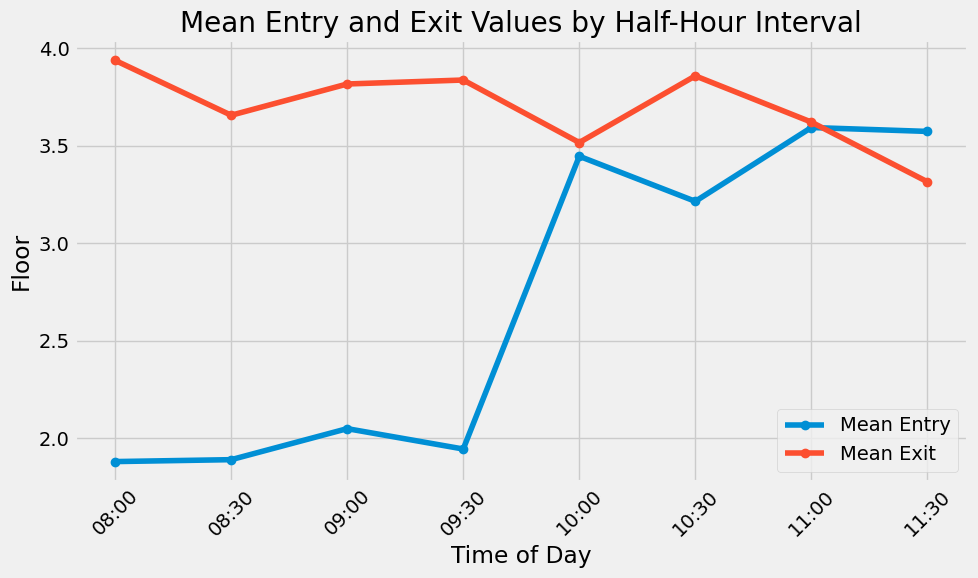

In [16]:
# Show line chart with entry and exits by time of day
plot_mean_floor_by_half_hour(entries_df)

## Run simulations

In [ ]:
all_wait_times = {}
for function in function_dict:
    print(f'-----------------')
    print(f'Function: {function}')
    wait_times = single_simulation(
        algorithm=function, 
        function_dict=function_dict, 
        data=entries_df, 
        floors=floors, 
        max_elevator_capacity=6, 
        animate=True, 
        animation_speed=0.1
    )
    all_wait_times[function] = wait_times

-----------------
Function: baseline_algorithm


In [23]:
# Create a results DataFrame from the all_wait_times dictionary
df_result = pd.DataFrame(all_wait_times)

# Calculate the required columns
df_result = pd.DataFrame({
    'Name': df_result.columns,
    'Shortest Wait': df_result.min(),
    'Longest Wait': df_result.max(),
    'Average Wait': round(df_result.mean(),2)
}).reset_index(drop=True)

df_result

,Name,Shortest Wait,Longest Wait,Average Wait
0,baseline_algorithm,3,30,15.51


## Create subplots

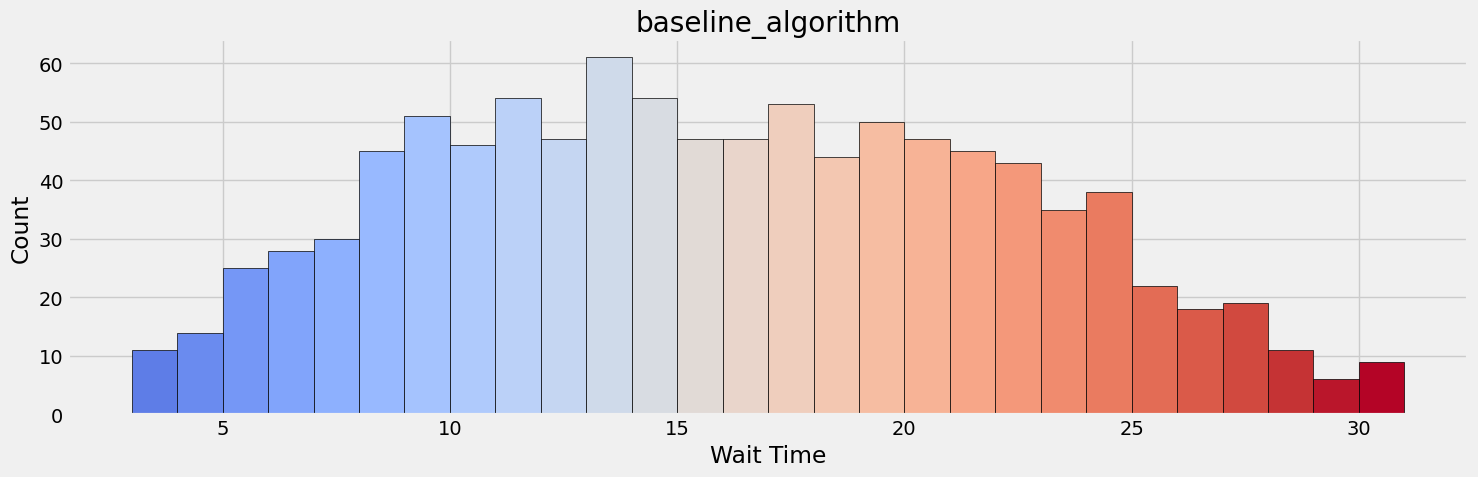

In [20]:
# Create subplots
# Maximum number of subplots per row
max_cols = 3

# Determine the number of rows and columns
num_subplots = len(function_dict)
num_rows = math.ceil(num_subplots / max_cols)
num_cols = min(num_subplots, max_cols)

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, tight_layout=True, figsize=(15, 5 * num_rows))

# If there's only one row or one column, axs won't be a 2D array, so we need to handle that
axs = axs.flatten() if num_subplots > 1 else [axs]

# Normalize and create colormap for wait times
max_wait_time = max(value for values in all_wait_times.values() for value in values)
norm = mcolors.Normalize(vmin=0, vmax=max_wait_time)
cmap = plt.get_cmap('coolwarm')  # Blue (low) to Red (high)

# Plot histograms for each algorithm in a separate subplot
for ax, (name, values) in zip(axs, all_wait_times.items()):
    # Create a histogram
    counts, bins = np.histogram(values, bins=range(min(values), max(values) + 2))

    # Assign colors based on the mid-point of each bin
    bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Calculate bin centers
    colors = cmap(norm(bin_centers))  # Map bin centers to colors

    # Plot the histogram with the corresponding colors
    ax.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color=colors, edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Wait Time')
    ax.set_ylabel('Count')
    ax.grid(True)

# Display the plot
plt.show()